In [10]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [11]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `car-trainer-k.png` available as well):
![car-trailer](car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [12]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    
    def set_state(self, x=None, y=None, θ0=None, θ1=None, ϕ=0):

        self.ϕ = ϕ  # car initial steering angle
        
        self.θ0 = θ0 
        self.θ1 = θ1 
        self.x = x 
        self.y = y 

        # Draw, if display is True
        if self.display: self.draw()
    
    
    def reset(self, x=None, y=None, θ0=None, θ1=None, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = θ0 if θ0 else random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = θ1 if θ1 else (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = x if x else (random() * .75 + 0.25) * self.box[1]
        self.y = y if y else (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
#             print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

In [13]:
truck = Truck()

In [ ]:
ϕ = deg2rad(-35)  # positive left, negative right
truck.step(ϕ)
truck.draw()

<IPython.core.display.Javascript object>


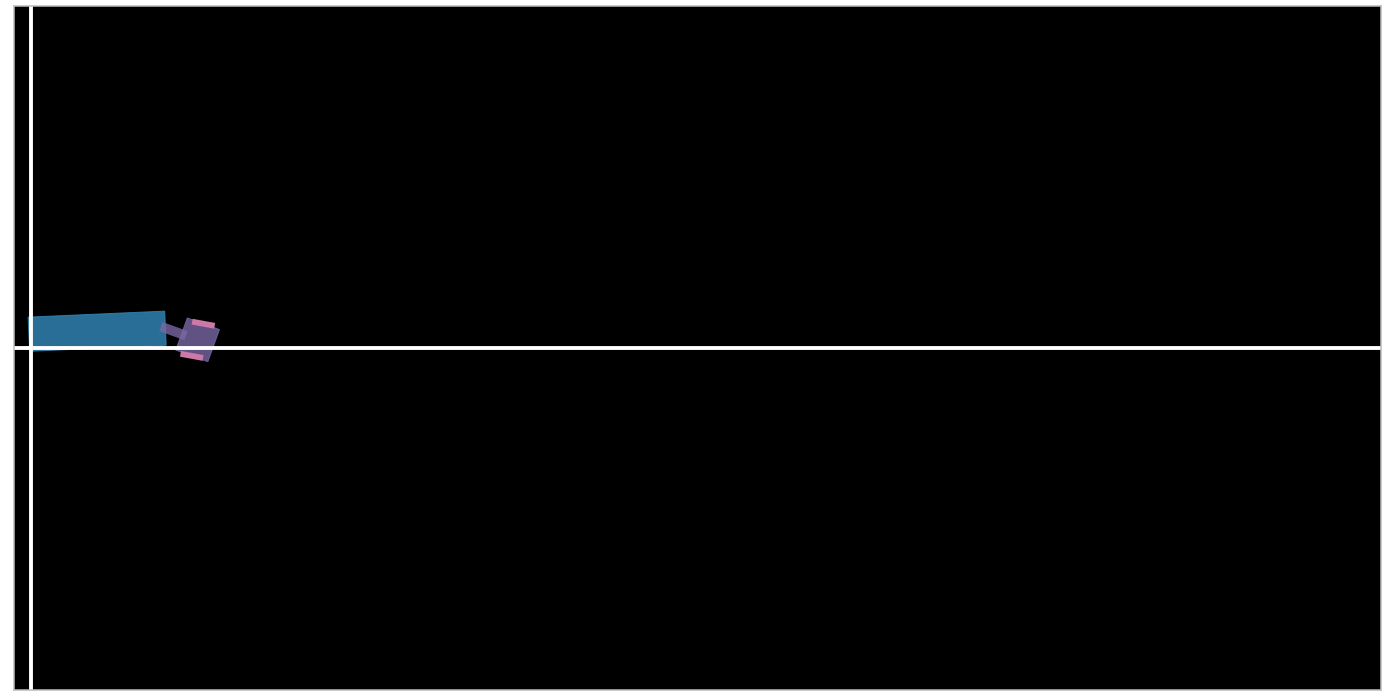

In [23]:
truck = Truck(display=True)
truck.reset()

In [122]:
# run the sequence to watch the truck park itself (after loading model)
truck.reset()
controller.eval()
emulator.eval()

start_x = 8
start_y = -3.5
start_θ0 = 0
start_θ1 = 0

x = start_x + random()
y = start_y + random() * start_y * -2
θ0 = deg2rad(start_θ0 + random() * start_θ0 * -2)
θ1 = deg2rad(start_θ1 + random() * start_θ1 * -2) 

truck.set_state(x, y, θ0, θ1)

def get_control(ϕ=None):

    ϕ = ϕ if ϕ is not None else truck.state()
    print(ϕ[:6])
    ϕ = torch.tensor(ϕ).to(device)
    target = torch.tensor([0.,0.,0.]).to(device)
    with torch.no_grad():
        control = controller(ϕ)
        next_predicted_φ_state = emulator(torch.cat([control, ϕ]))
#         print(f"predicted state {next_predicted_φ_state}")
    distance_to_goal = criterion(next_predicted_φ_state[2:5], target).item()
    print(f"{distance_to_goal} remaining")
                                            
    return control



ϕ = None
step_count = 0 
sequence_count = 0
sequence_theshold =  1
step_distance = 1
control = get_control(ϕ)


while truck.valid():
    steering_angle = control.item()
    ϕ = truck.step(steering_angle, step_distance)

    truck.draw()
    step_count += 1


    control = get_control(ϕ)


print(f"actual final state: {truck.state()} in {step_count} steps")

(8.78845543283281, 0.3268519454016734, 0.0, 4.78845543283281, 0.3268519454016734, 0.0)
11.616002082824707 remaining
(8.68845543283281, 0.3268519454016734, 0.009933340334325642, 4.688455432832811, 0.3268519454016734, 0.0)
11.29680347442627 remaining
(8.588460366354754, 0.3258586277037454, 0.019074881355495264, 4.588460489689759, 0.32685194539146417, -0.0002483294244819999)
10.981925964355469 remaining
(8.488478558358082, 0.3239512552397005, 0.02741549179833652, 4.488479628190367, 0.3268767735066274, -0.0007313796319361923)
10.671436309814453 remaining
(8.388516136463851, 0.3212100494758875, 0.03494677841221097, 4.388520254674983, 0.3269498815372813, -0.0014349585078036525)
10.365389823913574 remaining
(8.288577194115515, 0.3177160829196967, 0.04166095629057956, 4.288588185607596, 0.3270932795071227, -0.0023443012941376505)
10.063846588134766 remaining
(8.188663963328402, 0.31355119232315076, 0.04755096877448211, 4.188687686647464, 0.32732747591835515, -0.0034440777075499867)
9.766851425

In [14]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [15]:
truck = Truck();

In [16]:
# Build expert data set

# episodes = 10
inputs = list()
outputs = list()
truck = Truck(); episodes = 10_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

100%|██████████| 10000/10000 [00:16<00:00, 599.65it/s]


In [ ]:
len(inputs), len(outputs)

In [17]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

emulator = emulator.to(device)

In [ ]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [18]:
tensor_inputs = torch.load('tensor_inputs.pt')
tensor_outputs = torch.load('tensor_outputs.pt')

In [ ]:
# torch.save(tensor_inputs, 'tensor_inputs.pt')
# torch.save(tensor_outputs, 'tensor_outputs.pt')

In [ ]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [ ]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

In [19]:
train_inputs = torch.load('train_inputs.pt')
train_outputs = torch.load('train_outputs.pt')
test_inputs = torch.load('test_inputs.pt')
test_outputs = torch.load('test_outputs.pt')


# torch.save(train_inputs, 'train_inputs.pt')
# torch.save(train_outputs, 'train_outputs.pt')
# torch.save(test_inputs, 'test_inputs.pt')
# torch.save(test_outputs, 'test_outputs.pt')

# train_inputs = Variable(train_inputs.to(device), requires_grad=True) # add gradients so that we can backprop
# train_outputs = Variable(train_outputs.to(device), requires_grad=True)

train_inputs = train_inputs.to(device)
train_outputs = train_outputs.to(device)
test_inputs = test_inputs.to(device)
test_outputs = test_outputs.to(device)

In [ ]:
len(train_inputs)

In [ ]:
# Train... BUG! Can you spot it?
# What is one of the main assumptions for training a net?


cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ_state = train_inputs[i]
    next_state_prediction = emulator(ϕ_state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state)
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

In [20]:
# load the emulator model
path = "emulator.pth"
emulator.load_state_dict(torch.load(path))
emulator.eval()

Sequential(
  (0): Linear(in_features=7, out_features=45, bias=True)
  (1): ReLU()
  (2): Linear(in_features=45, out_features=6, bias=True)
)

In [ ]:
path = "emulator.pth"
torch.save(emulator.state_dict(), path)

In [ ]:
# Test

emulator.eval()
emulator_validation_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)
        
        next_state = test_outputs[idx]
        emulator_validation_loss += criterion(next_state_prediction, next_state).item()

    

In [ ]:
print(f'Test loss: {emulator_validation_loss:.10f}')

In [21]:
state_size = 6
steering_size = 1
hidden_units_c = 25

class HalfPiSigmoid(nn.Module):
    """Returns Sigmoid with the range -pi/2 to pi/2 """
    def forward(self, x):
        return (torch.sigmoid(x) - 0.5) * pi



controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.ReLU(),
    nn.Linear(hidden_units_c, steering_size),
    HalfPiSigmoid()
)

# optimiser_c = SGD(emulator.parameters(), lr=0.005)
optimiser_c = torch.optim.Adam(emulator.parameters(), lr=0.01)
criterion_c = nn.MSELoss()

controller = controller.to(device)

In [22]:
path = "controller.pth"
controller.load_state_dict(torch.load(path))
controller.eval()

Sequential(
  (0): Linear(in_features=6, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=1, bias=True)
  (3): HalfPiSigmoid()
)

In [ ]:
# save the pretrained controller model
path = "controller.pth"
torch.save(controller.state_dict(), path)

In [ ]:
# training code using just the controller and emulator
truck = Truck()
emulator.eval()
controller.train()

target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
cnt = 0

running_loss = 0
last_running_loss = inf
running_step_count = 0
steps = 0
batch_steps = 0
early_stop_threshold = 5
successful_runs = 0
jackknifes = 0
start_x = 4.25
start_y = -0.25
start_θ0 = 0
start_θ1 = 0



while start_x <= 20:

    batch_steps += steps
    steps = 0
    emulator_steps = 0
    truck_steps = 0

    stop_conditions = False
    x = start_x + random()
    y = start_y + random() * start_y * -2
    θ0 = deg2rad(start_θ0 + random() * start_θ0 * -2)
    θ1 = deg2rad(start_θ1 + random() * start_θ1 * -2) 

    truck.set_state(x=x, y=y,θ0=θ0, θ1=θ1 )

    ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)
    initial_ϕ_state = ϕ_state.clone()

    if not truck.valid():
        print ("invalid start")
        continue


    start_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"
    last_ϕ_state = ϕ_state
    last_actual_ϕ_state = ϕ_state

    sum_loss = 0
    step_distance = 0.25

    loss_controller = 0
    loss_actual = 0

    best_loss = inf

    stop_conditions = False
    docked = False
    loss_controller = 0


    while truck.valid():
        x, y, θ0, x2, y2, θ1 = ϕ_state.clone().detach()

        truck_ϕ_state = torch.tensor(truck.state(), requires_grad=True).to(device)

        predicted_steering_control = controller(ϕ_state)
        control = predicted_steering_control.clone().detach().cpu().item()
        next_truck_ϕ_state = torch.tensor(truck.step(control), requires_grad=True).to(device)
        truck.draw()
        steps += 1
        if truck.valid():
            ϕ_state = emulator(torch.cat([predicted_steering_control, truck_ϕ_state]))
            loss_controller += criterion_c(θ0, θ1) ** 2  # don't jackknife
            loss_controller += criterion_c(ϕ_state, next_truck_ϕ_state) # loss from emulator innacuracy
            loss_controller /= steps
    if steps > 1:    
        loss_controller += criterion_c(next_truck_ϕ_state[3:], target)  #actual position
        loss_controller += criterion_c(θ0, θ1) ** 2  # don't jackknife



    actual_final_state = f"({next_truck_ϕ_state[0].item():.2f},{next_truck_ϕ_state[1].item():.2f},{next_truck_ϕ_state[2].item():.2f}, {next_truck_ϕ_state[3].item():.2f},{next_truck_ϕ_state[4].item():.2f},{next_truck_ϕ_state[5].item():.2f})"
    predicted_final_state = f"({ϕ_state[3].item():.2f},{ϕ_state[4].item():.2f},{ϕ_state[5].item():.2f})"





    jackknifed = truck.is_jackknifed()
    offscreen = truck.is_offscreen()

    loss_target = 6


    if loss_controller < loss_target:
        successful_runs += 1

    if jackknifed:
        jackknifes += 1


    controller.zero_grad()
    emulator.zero_grad()

    if loss_controller == 0:
        print("No Loss")
        continue

    final_loss = loss_controller.item()
    loss_controller.backward()

    optimiser_c.step()



    running_loss += final_loss
    running_step_count += steps

    display_threshold = 1000

    if cnt == 0 or (cnt + 1) % display_threshold == 0:
        print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, predicted final state: {predicted_final_state}, actual final state: {actual_final_state}, θ0, θ1: {θ0},{θ1} last move: {control:.3f}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
    cnt += 1

    summary_threshold = 2_000

    if (cnt + 1) % summary_threshold == 0:
        print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


        if running_loss > last_running_loss:
            early_stop_count += 1
        else:
            early_stop_count = 0

        print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")
        # scheduler
        avg_loss = running_loss/summary_threshold
        if avg_loss < loss_target:
            early_stop_count = 0
            start_x += 0.25
            start_y -= 0.25
#             start_θ0 -= 1
#             start_θ1 -= 1
            print(f"Avg. loss is {avg_loss}. Increasing starting position to {start_x}, {start_y}\n\n")



        if early_stop_count > early_stop_threshold:
            break

        last_running_loss = running_loss
        running_loss = 0
        running_step_count = 0
        successful_runs = 0
        jackknifes = 0
    

In [ ]:
print(f"Final starting x,y,θ0,θ1: {start_x}, {start_y}, {start_θ0}, {start_θ1}\n\n")